In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_selection import mutual_info_classif


# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('data/Train.csv')  # Training dataset
test = pd.read_csv('data/Test.csv')  # Test dataset (no labels)
ss = pd.read_csv('data/SampleSubmission.csv')  # Sample submission format
variables = pd.read_csv('data/VariableDefinitions.csv')  # Data dictionary

In [3]:
train.shape

(23524, 13)

In [4]:
train.nunique()

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

In [5]:
train.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

In [6]:
train['country'].unique()

array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object)

In [7]:
train['job_type'].unique()

array(['Self employed', 'Government Dependent',
       'Formally employed Private', 'Informally employed',
       'Formally employed Government', 'Farming and Fishing',
       'Remittance Dependent', 'Other Income',
       'Dont Know/Refuse to answer', 'No Income'], dtype=object)

In [8]:
train['education_level'].unique()

array(['Secondary education', 'No formal education',
       'Vocational/Specialised training', 'Primary education',
       'Tertiary education', 'Other/Dont know/RTA'], dtype=object)

### Train test split

In [9]:
X = train.drop('bank_account', axis = 1)
y = train[['bank_account']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)
# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 17643 samples.
Testing set has 5881 samples.


### EDA

In [11]:
df = pd.concat([X_train, y_train], axis=1)

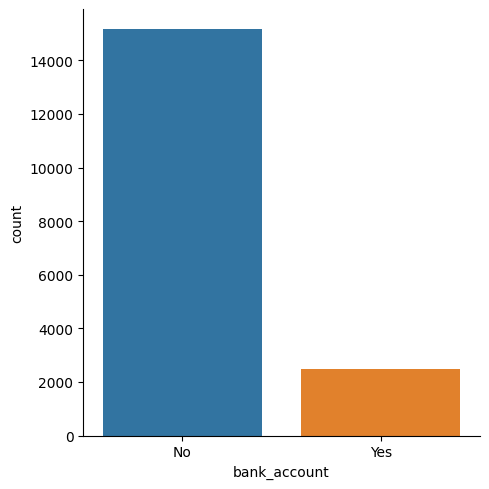

In [12]:
sns.catplot(x="bank_account", kind="count", data=df)

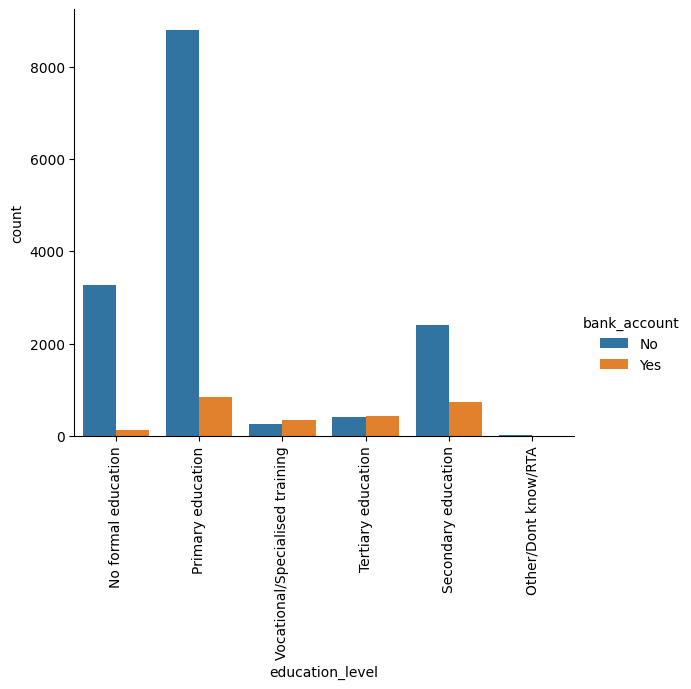

In [13]:
sns.catplot(
    data=df,
    x="education_level",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

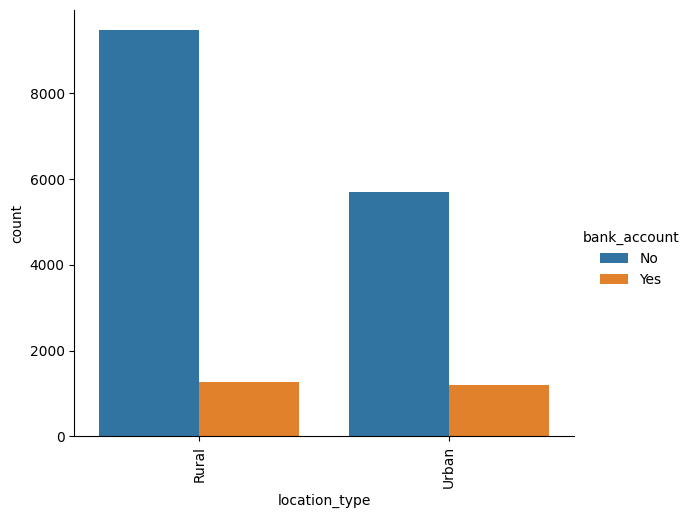

In [14]:
sns.catplot(
    data=df,
    x="location_type",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

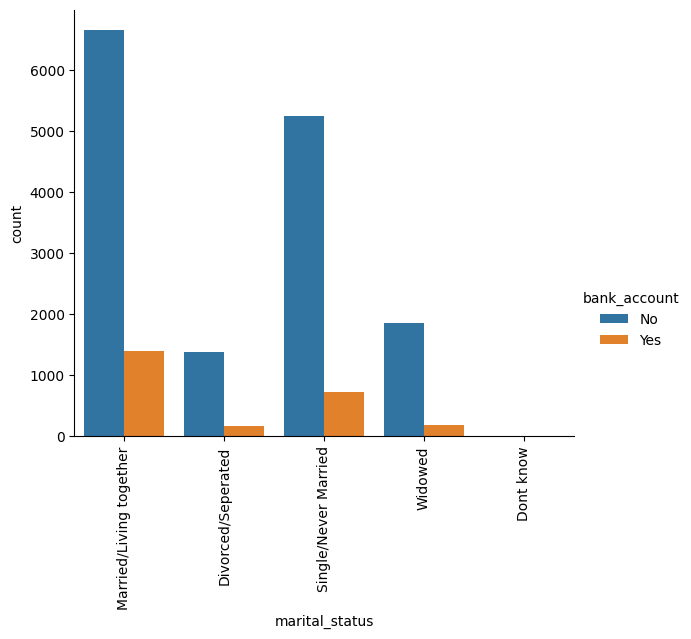

In [15]:
sns.catplot(
    data=df,
    x="marital_status",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

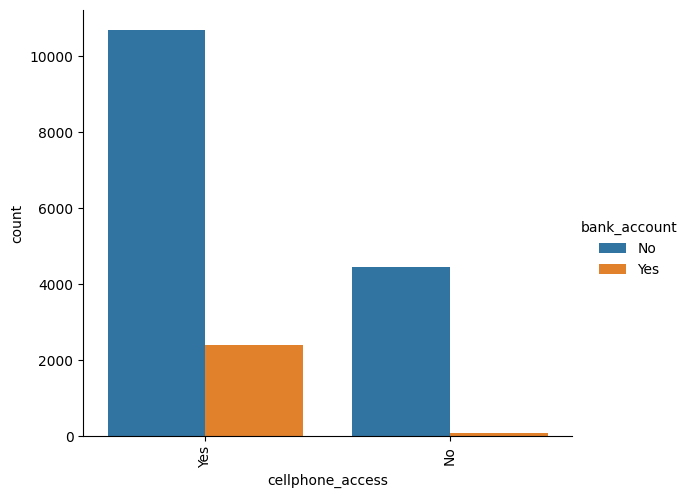

In [16]:
sns.catplot(
    data=df,
    x="cellphone_access",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

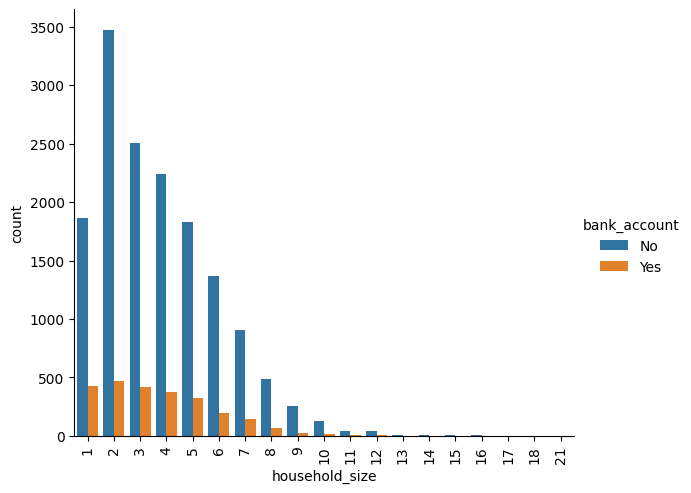

In [17]:
sns.catplot(
    data=df,
    x="household_size",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

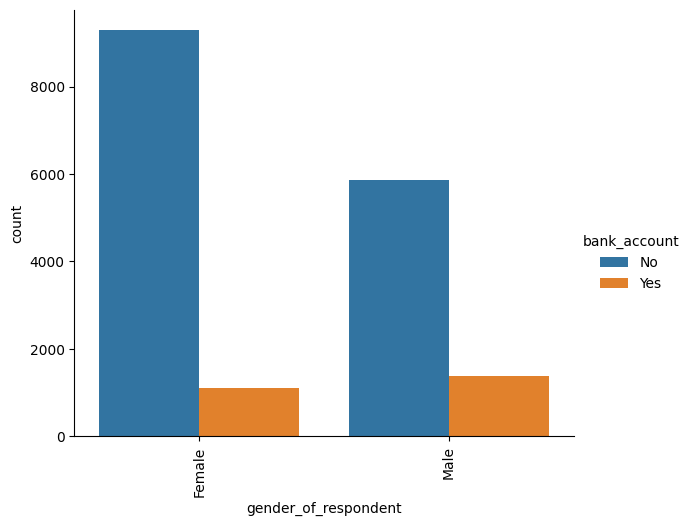

In [18]:
sns.catplot(
    data=df,
    x="gender_of_respondent",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

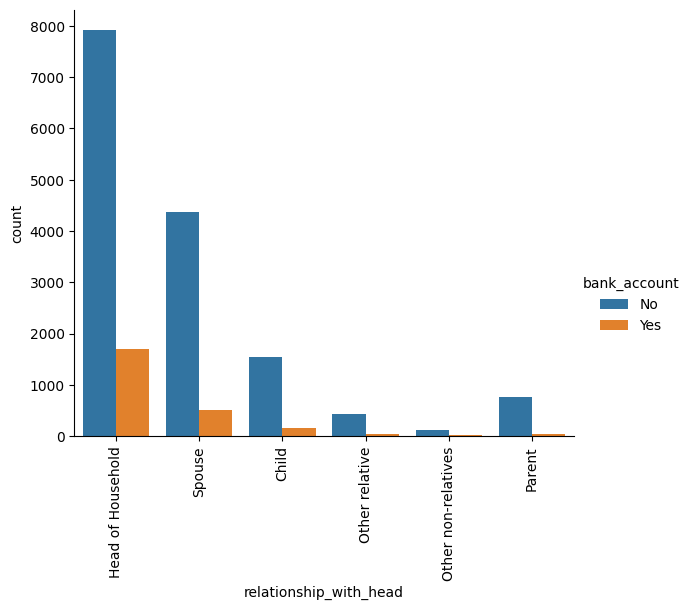

In [19]:
sns.catplot(
    data=df,
    x="relationship_with_head",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

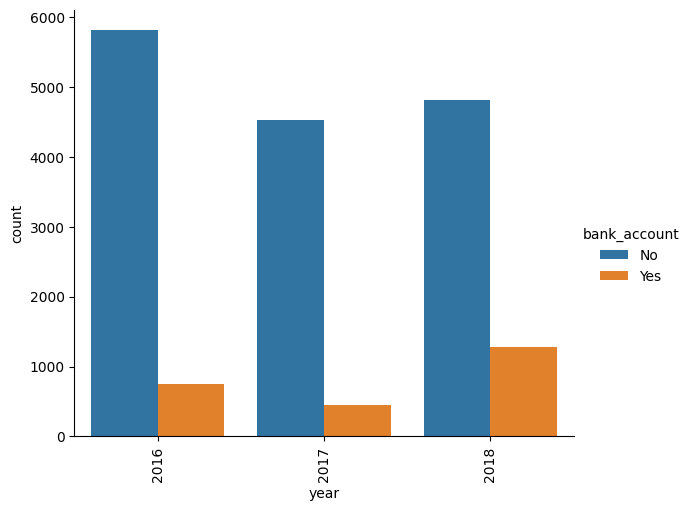

In [20]:
sns.catplot(
    data=df,
    x="year",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

In [21]:
df['age_bin'] = pd.cut(train['age_of_respondent'], bins=5)

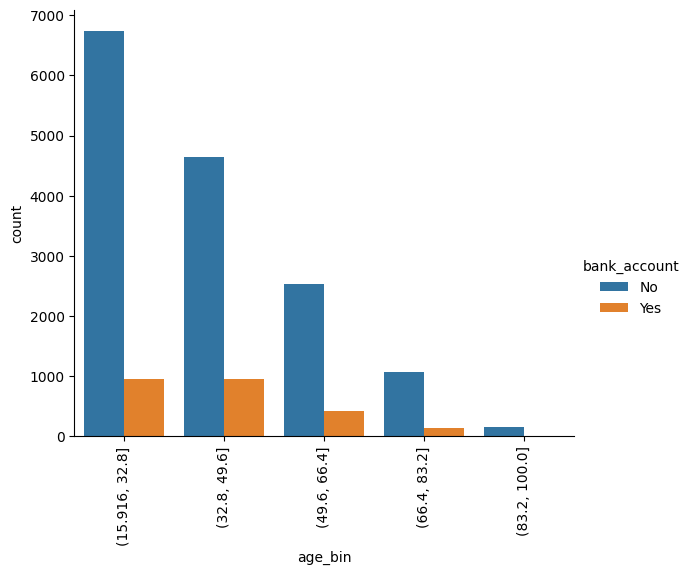

In [22]:
sns.catplot(
    data=df,
    x="age_bin",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

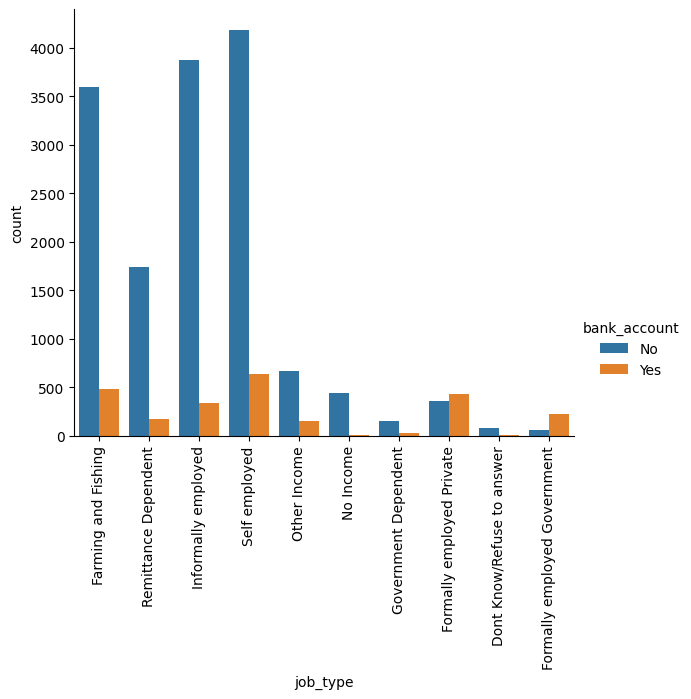

In [23]:
sns.catplot(
    data=df,
    x="job_type",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

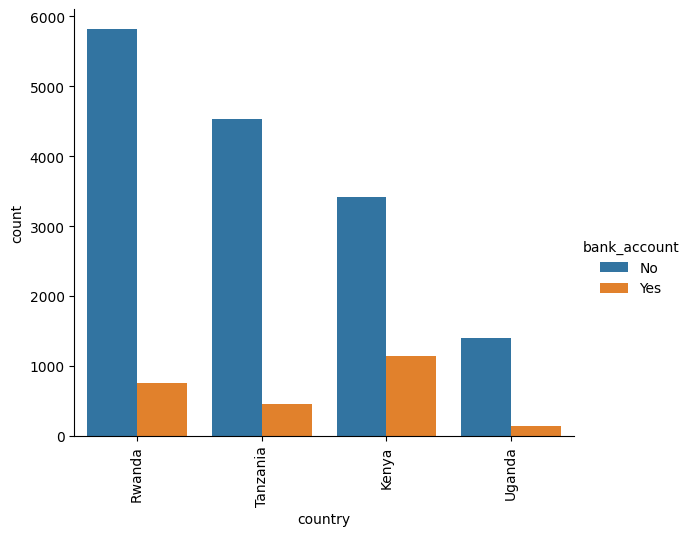

In [24]:
sns.catplot(
    data=df,
    x="country",
    hue="bank_account",
    kind="count",
    height=5,
    aspect=1.2
)

plt.xticks(rotation=90)
plt.show()

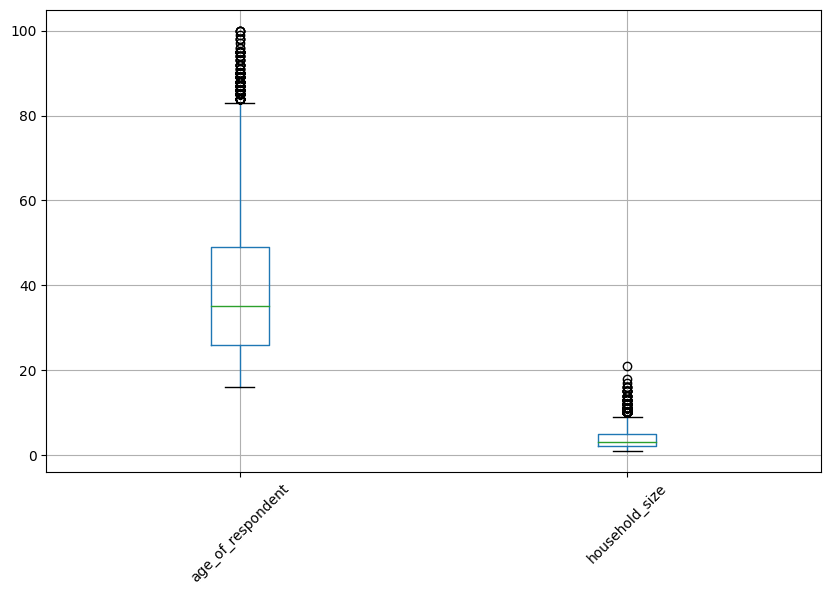

In [25]:
df[['age_of_respondent', 'household_size']].boxplot(figsize=(10, 6))
plt.xticks(rotation=45)
plt.show()

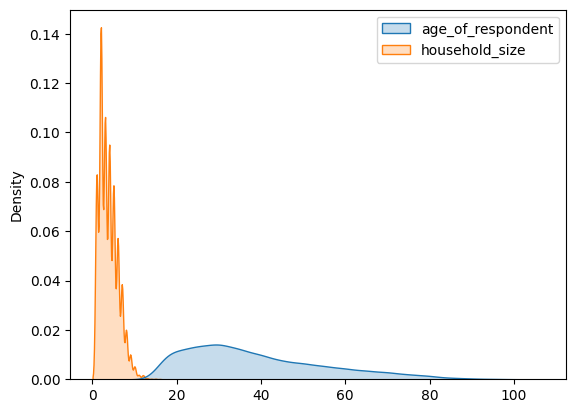

In [26]:
sns.kdeplot(df[['age_of_respondent', 'household_size']], fill=True)
plt.show()

### Cleaning

In [27]:
y_train['bank_account'] = y_train['bank_account'].map({'Yes': 1, 'No': 0})
y_test['bank_account'] = y_test['bank_account'].map({'Yes': 1, 'No': 0})

In [28]:
categorical_variables = ['country', 'year', 'location_type',
       'cellphone_access','gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']
numerical_variables = ['household_size', 'age_of_respondent']

In [29]:
def clean(df_in):
    df = df_in.copy(deep=True)
    df = df.drop('uniqueid', axis = 1)
    df[numerical_variables] = df[numerical_variables].astype(float)
    return df

In [30]:
X_train = clean(X_train)
X_test = clean(X_test)

### Pipeline for data cleaning and feature engineering

In [31]:
categorical_steps = [('ohe', OneHotEncoder(drop = 'first',sparse_output=False))]
categorical_pipeline = Pipeline(steps=categorical_steps)
numerical_steps = [('scaler', RobustScaler())]
numerical_pipeline = Pipeline(steps=numerical_steps)
transformers = [('categorical_pipeline', categorical_pipeline, categorical_variables),
                  ('numerical_pipeline', numerical_pipeline, numerical_variables)]

preprocessor = ColumnTransformer(transformers=transformers,
                                         remainder = 'drop').set_output(transform='pandas')

In [32]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('categorical_pipeline',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['country', 'year', 'location_type',
                                  'cellphone_access', 'gender_of_respondent',
                                  'relationship_with_head', 'marital_status',
                                  'education_level', 'job_type']),
                                ('numerical_pipeline',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['household_size', 'age_of_respondent'])])

In [33]:
X_train_preprocessed = preprocessor.transform(X_train)

In [34]:
X_train_preprocessed.shape

(17643, 33)

In [35]:
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed.shape

(5881, 33)

## Baseline Model

### Feature selection

In [36]:
mi = mutual_info_classif(X_train_preprocessed, y_train, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X_train_preprocessed.columns)
mi_series = mi_series.sort_values(ascending=False)
top_k = 5
top_features = mi_series.head(top_k).index.tolist()
print(top_features)

['categorical_pipeline__cellphone_access_Yes', 'categorical_pipeline__job_type_Formally employed Private', 'categorical_pipeline__education_level_Primary education', 'categorical_pipeline__education_level_Tertiary education', 'categorical_pipeline__job_type_Formally employed Government']


In [37]:
X_train_preprocessed[top_features]

,categorical_pipeline__cellphone_access_Yes,categorical_pipeline__job_type_Formally employed Private,categorical_pipeline__education_level_Primary education,categorical_pipeline__education_level_Tertiary education,categorical_pipeline__job_type_Formally employed Government
8561,1.0,0.0,0.0,0.0,0.0
12157,1.0,0.0,1.0,0.0,0.0
17751,0.0,0.0,1.0,0.0,0.0
7461,0.0,0.0,1.0,0.0,0.0
15747,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
13297,1.0,0.0,1.0,0.0,0.0
14158,1.0,0.0,1.0,0.0,0.0
21715,1.0,0.0,0.0,0.0,0.0
13529,1.0,0.0,0.0,0.0,0.0


### Logistic regression baseline model

In [38]:
baseline = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [39]:
baseline.fit(X_train_preprocessed[top_features],y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [40]:
y_test_pred_baseline = baseline.predict(X_test_preprocessed[top_features])
y_test_pred_baseline_probs = baseline.predict_proba(
    X_test_preprocessed[top_features]
)[:, 1]

In [41]:
y_test_pred_baseline_probs

array([0.06660078, 0.12004877, 0.57172417, ..., 0.57172417, 0.41113892,
       0.41113892])

In [42]:
print(f"Baseline MAE = {mean_absolute_error(y_test, y_test_pred_baseline)}")
print(f"Baseline roc curve score = {roc_auc_score(y_test, y_test_pred_baseline_probs)}")

Baseline MAE = 0.3057303179731338
Baseline roc curve score = 0.7723741862824112


## Modelling

### Adaboost without hyperparameter tuning

In [43]:
pipeline_ad = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
    class_weight='balanced'),
    random_state=42))
])

In [44]:
pipeline_ad.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['country', 'year',
                                                   'location_type',
                                                   'cellphone_access',
                                                   'gender_of_respondent',
                                                   'relationship_with_head',
                                                   'marital_status',
                                                   'education_level',
                                                   'job_type']),
                                                 ('numerical_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['household_size',
                                                   'age_of_respondent'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=1),
                                    random_state=42))])

In [45]:
y_test_pred_ad = pipeline_ad.predict(X_test)
y_test_pred_ad_probs = pipeline_ad.predict_proba(X_test)[:, 1]

In [46]:
print(f"Adaboost MAE = {mean_absolute_error(y_test, y_test_pred_ad)}")
print(f"Adaboost roc curve score = {roc_auc_score(y_test, y_test_pred_ad_probs)}")

Adaboost MAE = 0.22309131100153035
Adaboost roc curve score = 0.8607698014572105


### Adaboost with hyperparameter tuning and oversampling

In [47]:
y_train.value_counts()

bank_account
0               15159
1                2484
Name: count, dtype: int64

In [48]:
ros = RandomOverSampler(random_state=10, sampling_strategy={1: 15_000}) 

# pipeline
ros_pipeline = imb_pipe(ros, pipeline_ad)

In [49]:
param_grid = {
    'pipeline__preprocessor__numerical_pipeline__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'pipeline__classifier__n_estimators': [100, 200, 300],
    'pipeline__classifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'pipeline__classifier__estimator__min_samples_split' : np.arange(2, 8, 2),  
    'pipeline__classifier__estimator__max_depth': [1, 2]
}

In [50]:
random_search = RandomizedSearchCV(
    estimator=ros_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',  # or recall, f1, roc_auc
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [52]:
random_search.fit(X_train, y_train.iloc[:, 0])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomoversampler',
                                              RandomOverSampler(random_state=10,
                                                                sampling_strategy={1: 15000})),
                                             ('pipeline',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(transformers=[('categorical_pipeline',
                                                                                                Pipeline(steps=[('ohe',
                                                                                                                 OneHotEncoder(drop='first',
                                                                                                                               sparse_output=False))]),
                                                                                                ['country',
                                                                                                 'year',
                                                                                                 'location_type',
                                                                                                 'cellph...
                   param_distributions={'pipeline__classifier__estimator__max_depth': [1,
                                                                                       2],
                                        'pipeline__classifier__estimator__min_samples_split': array([2, 4, 6]),
                                        'pipeline__classifier__learning_rate': [0.01,
                                                                                0.1,
                                                                                0.5,
                                                                                1.0],
                                        'pipeline__classifier__n_estimators': [100,
                                                                               200,
                                                                               300],
                                        'pipeline__preprocessor__numerical_pipeline__scaler': [StandardScaler(),
                                                                                               MinMaxScaler(),
                                                                                               RobustScaler()]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [53]:
best_model = random_search.best_estimator_
print(best_model)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=10,
                                   sampling_strategy={1: 15000})),
                ('pipeline',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('categorical_pipeline',
                                                                   Pipeline(steps=[('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  sparse_output=False))]),
                                                                   ['country',
                                                                    'year',
                                                                    'location_type',
                                                                    'cellphone_access',
                   

In [54]:
y_test_pred_ad_rnd_hyp = best_model.predict(X_test)
y_test_pred_ad_rnd_hyp_probs = best_model.predict_proba(X_test)[:, 1]

In [55]:
print(f"Adaboost Random Oversample with tuning: MAE = {mean_absolute_error(y_test, y_test_pred_ad_rnd_hyp)}")
print(f"Adaboost Random Oversample with tuning: roc curve score = {roc_auc_score(y_test, y_test_pred_ad_rnd_hyp_probs)}")

Adaboost Random Oversample with tuning: MAE = 0.2052372045570481
Adaboost Random Oversample with tuning: roc curve score = 0.8659803904697166


In [58]:
test_copy = test.copy(deep=True)

In [59]:
test_copy = clean(test_copy)

In [60]:
y_final_test = best_model.predict(test_copy)

In [61]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": y_final_test})

In [62]:
submission

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,1
10083,uniqueid_3000 x Uganda,1
10084,uniqueid_3001 x Uganda,0


In [64]:
# Create submission csv file csv file
submission.to_csv('first_submission1.csv', index = False)